In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from copy import copy as cp
from torch.optim.lr_scheduler import MultiStepLR

In [2]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [3]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev

device(type='cuda')

In [4]:
class Encoder1(nn.Module):
   def __init__(self, sz):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
                                nn.Conv2d(1, 1, 7),
                                nn.BatchNorm2d(1),
                                nn.ReLU(),
                                nn.Conv2d(1, 1, 7),
                                nn.BatchNorm2d(1),
                                nn.ReLU(),
                                nn.Conv2d(1, 1, 7),
                                nn.BatchNorm2d(1),
                                nn.ReLU(),
                                nn.Flatten(),
                                nn.Linear(100, 100), nn.BatchNorm1d(100), nn.ReLU())
        self.mu = nn.Linear(100, sz)
        self.log_std = nn.Linear(100, sz)
   def forward(self, x):
    z = self.conv(x)
    mu = self.mu(z)
    log_std = self.log_std(z)
    return mu, log_std

In [5]:
class Encoder(nn.Module):
   def __init__(self, sz):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(nn.Flatten(),
                                nn.Linear(784, 500), nn.BatchNorm1d(500), nn.ReLU())
        self.mu = nn.Linear(500, sz)
        self.log_std = nn.Linear(500, sz)
   def forward(self, x):
    z = self.conv(x)
    mu = self.mu(z)
    log_std = self.log_std(z)
    return mu, log_std

In [6]:
class Decoder(nn.Module):
    def __init__(self, sz):
        super(Decoder, self).__init__()
        self.d1 = nn.Sequential(nn.Linear(sz, 500), nn.BatchNorm1d(500), nn.ReLU(),
                                nn.Linear(500, 784), nn.BatchNorm1d(784), nn.ReLU())
        self.d2 = nn.Sequential(nn.Conv2d(1, 3, 3, padding=1),
                               nn.BatchNorm2d(3),
                               nn.ReLU(),
                               nn.Conv2d(3, 2, 3, padding=1),
                               nn.BatchNorm2d(2),
                               nn.ReLU(),
                               nn.Conv2d(2, 1, 3, padding=1),
                               nn.BatchNorm2d(1),
                               nn.ReLU(),
                               nn.Flatten(),
                               nn.Linear(784, 784), nn.BatchNorm1d(784), nn.ReLU())
    def forward(self, z):
        z1 = self.d1(z)
        z1 = z1.reshape(z1.shape[0], 1, 28, 28)
        z2 = self.d2(z1)
        z2 = z2.reshape(z1.shape[0], 1, 28, 28)
        return z2

In [7]:
class Decoder1(nn.Module):
    def __init__(self, sz):
        super(Decoder, self).__init__()
        self.d1 = nn.Sequential(nn.Linear(sz, 500), nn.BatchNorm1d(500), nn.ReLU())
        self.d2 = nn.Sequential(nn.Linear(500, 784), nn.BatchNorm1d(784), nn.ReLU())
    def forward(self, z):
        z1 = self.d1(z)
        z2 = self.d2(z1)
        z2 = z2.reshape(z1.shape[0], 1, 28, 28)
        return z2

In [8]:
class VAEFitter(object):
  def __init__(self, encoder, decoder, batch_size=64, n_epochs=15, latent_dim=300, lr=0.0001, KL_weight=0.001):
        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight
        self.criterion = nn.MSELoss()
        self.opt  = torch.optim.Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=self.lr)
        self.encoder = self.encoder.to(dev)
        self.decoder = self.decoder.to(dev)
  def gen_z(self, mu, log_std):
        eps = torch.randn(mu.shape).to(dev)
        return mu + torch.exp(log_std / 2) * eps
  def vae_loss(self, x, rec_x, mu, log_std):
        l1 = self.criterion(x, rec_x)
        KL = torch.mean(-0.5 * torch.sum(1 + log_std - mu**2 - log_std.exp(), dim = 1), dim = 0)
        return l1 + KL * self.KL_weight
  def compute_loss(self, x_batch):
        mu, log_std = self.encoder(x_batch)
        z_batch = self.gen_z(mu, log_std)
        x_batch_rec = self.decoder(z_batch)
        loss = self.vae_loss(x_batch, x_batch_rec, mu, log_std)
        return loss
  def fit(self, X):
        X_real = torch.tensor(X, dtype=torch.float, device=dev)
        dataset_real = TensorDataset(X_real)
        self.encoder.train(True)
        self.decoder.train(True)
        self.loss_history = []
        scheduler = MultiStepLR(self.opt, milestones=[110], gamma=0.1)
        for epoch in range(self.n_epochs):
            for (x_batch, ) in DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True):
                loss = self.compute_loss(x_batch)
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                self.loss_history.append(loss.detach().cpu())
            if epoch==35:
              self.KL_weight=0.001
              print("Change")
            if epoch%3==0:
              print(f'{epoch+1}/{self.n_epochs} Mean_loss = {sum(self.loss_history[-1000:])/1000}')
            scheduler.step()
        self.encoder.train(False)
        self.decoder.train(False)
        return cp(self.loss_history)

In [9]:
X = X.reshape(X.shape[0], 1, 28, 28)

In [10]:
%%time
latent_dim = 4
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
vae_fitter = VAEFitter(encoder, decoder,
                       batch_size=64, n_epochs=100, latent_dim=latent_dim,
                       lr=0.001, KL_weight=0.1)
q = vae_fitter.fit(X)

1/100 Mean_loss = 7155.884765625
4/100 Mean_loss = 6733.2890625
7/100 Mean_loss = 6343.41552734375
10/100 Mean_loss = 5965.60205078125
13/100 Mean_loss = 5614.1552734375
16/100 Mean_loss = 5283.68603515625
19/100 Mean_loss = 4970.775390625
22/100 Mean_loss = 4676.48388671875
25/100 Mean_loss = 4397.5693359375
28/100 Mean_loss = 4140.853515625
31/100 Mean_loss = 3895.66015625
34/100 Mean_loss = 3670.239013671875
Change
37/100 Mean_loss = 3451.601318359375
40/100 Mean_loss = 3257.173095703125
43/100 Mean_loss = 3076.108154296875
46/100 Mean_loss = 2910.931396484375
49/100 Mean_loss = 2755.7529296875
52/100 Mean_loss = 2610.84375
55/100 Mean_loss = 2491.581298828125
58/100 Mean_loss = 2374.66845703125
61/100 Mean_loss = 2276.143798828125
64/100 Mean_loss = 2183.47119140625
67/100 Mean_loss = 2105.109619140625
70/100 Mean_loss = 2036.3587646484375
73/100 Mean_loss = 1975.6533203125
76/100 Mean_loss = 1925.6070556640625
79/100 Mean_loss = 1878.37548828125
82/100 Mean_loss = 1843.85485839843

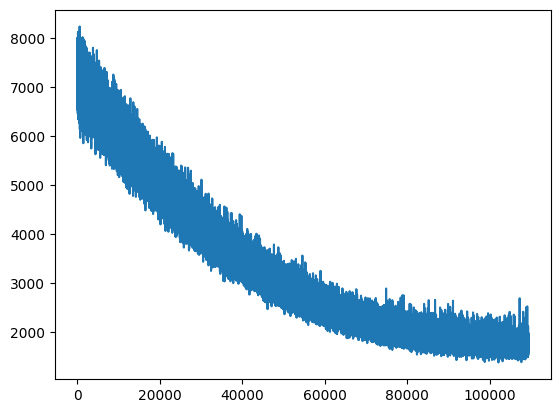

In [11]:
qw = list(range(len(q)))
plt.plot(qw, q)

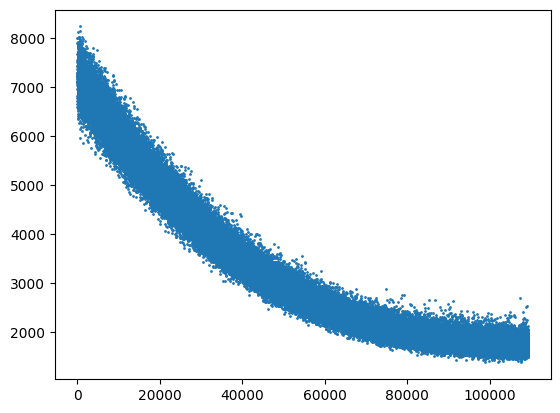

In [12]:
plt.scatter(range(len(vae_fitter.loss_history)), vae_fitter.loss_history, s=1)

In [53]:
N = 1000
Z = torch.normal(0, 1, (N, latent_dim))

In [54]:
decoder.train(False)
X_fake = decoder(Z.cuda()).cpu().detach().numpy()
Z = Z.cpu().detach().numpy()

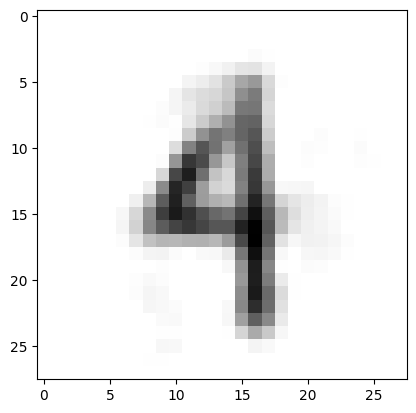

In [62]:
from random import randint
w = randint(0, 999)
plt.imshow(X_fake[w][0], cmap="Greys")

In [39]:
#torch.save(decoder.state_dict(), 'gen2.pth')

In [40]:
#from google.colab import files
#files.download('/content/gen2.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>